In [1]:
%matplotlib widget
%reset -f
%load_ext autoreload
%autoreload 2

import mechanics
from mechanics import *
from mechanics.lagrange import euler_lagrange_equation
import mechanics.space as space

t, = base_spaces('t')
def dot(f): return diff(f, t)

theta1, theta2 = variables(r'\theta_1 \theta_2', t, space=space.S)
q = (theta1, theta2)
dq = tuple(dot(q_n) for q_n in q)
ddq = tuple(dot(dq_n) for dq_n in dq)

g, m1, m2, l1, l2 = constants(r'g, m_1 m_2 \ell_1 \ell_2')

x1 = l1 * sin(theta1)
y1 = -l1 * cos(theta1)
x2 = x1 + l2 * sin(theta2)
y2 = y1 - l2 * cos(theta2)

U = m1 * g * y1 + m2 * g * y2
T = (m1 / 2 * (dot(x1)**2 + dot(y1)**2)
     + m2 / 2 * (dot(x2)**2 + dot(y2)**2)).simplify()
E = T + U
L = T - U
show('L =', L)

EL = euler_lagrange_equation(L, q)
show_equations(EL)

F = solve(EL, ddq)
show_equations(F)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
from mechanics.integrator.runge_kutta import rk4_explicit

h, T = constants('h T')
i, = indices('i')
X, K, step_eq, d = rk4_explicit(F, h, i)
show_equations(step_eq)

theta1, theta2 = d(q)
v_theta1, v_theta2 = d(dq)

<IPython.core.display.Math object>

In [3]:
with Solver() as solver:
    solver.constants(g, m1, m2, l1, l2)
    solver.constants(h, T)
    solver.variables(*X, *K, index=(i, 0, T/h))
    solver.functions('x1', 'y1', 'x2', 'y2', 'E', index=(i, 0, T/h))
    solver.inputs(*(x[0] for x in X))
    with solver.steps(i, 0, T/h) as step:
        step.solve_explicit(step_eq)
        step.calculate({'x1': d(x1), 'y1': d(y1), 'x2': d(x2), 'y2': d(y2), 'E': d(E)}, i)

Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpduyxkwde/generated.f90


In [4]:
import numpy as np
_ = solver.run({
    m1: 1.0, m2: 1.0, l1: 1.0, l2: 1.0, g: 1.0,
    h: 0.1, T: 10.0,
    theta1[0]: np.pi/2, theta2[0]: 0.0,
    v_theta1[0]: 0.0, v_theta2[0]: 0.0,
})


 Started
 Completed
Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp0sug9d1l/result.log, size=2128


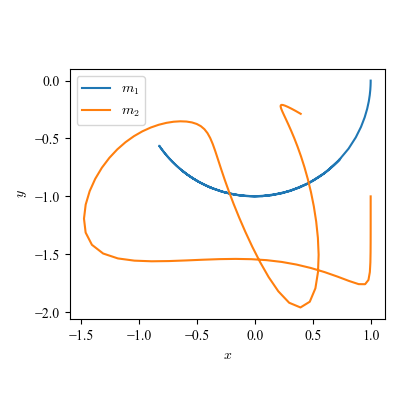

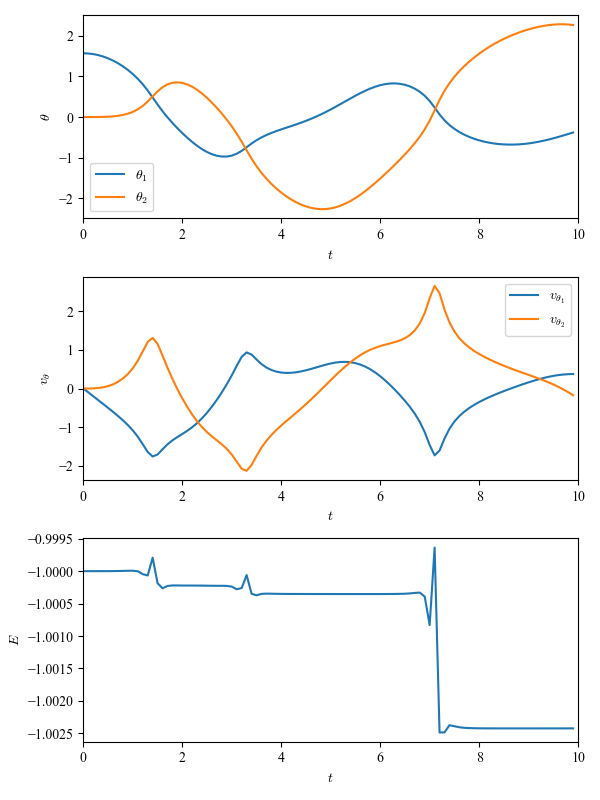

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

t = np.arange(0, _[T], _[h])

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.plot(_['x1'], _['y1'], label='$m_1$')
ax.plot(_['x2'], _['y2'], label='$m_2$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.legend()

fig, axes = plt.subplots(3, 1, figsize=(6, 8), tight_layout=True)
variables = [(r'\theta', (theta1, theta2)),
             (r'v_\theta', (v_theta1, v_theta2)), 
             ('E', ('E',))]
for ax, (name, vars) in zip(axes.flatten(), variables):
    for var in vars:
        ax.plot(t, _[var][:-1], label=f'${getattr(var, "name", var)}$')
    ax.set_xlabel('$t$')
    ax.set_ylabel(f'${name}$')
    ax.set_xlim(0, _[T])
    if len(vars) > 1:
        ax.legend()

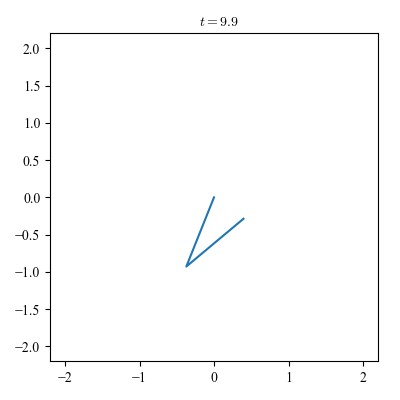

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(4, 4), tight_layout=True)

lim = (_[l1] + _[l2]) * 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect('equal')

line, = ax.plot([], [])
time = ax.text(-0.2, lim + 0.1, '')

def update(i):
    time.set_text(f'$t = {i * _[h]:.1f}$')
    line.set_data([0, _['x1'][i], _['x2'][i]], [0, _['y1'][i], _['y2'][i]])
    return line, time

ani = animation.FuncAnimation(fig, update, frames=range(0, int(_[T]/_[h]), 1), interval=10, blit=True)
# ani.save('motion.mp4', writer='ffmpeg', dpi=140)
